In [ ]:
# https://github.com/springcoil/probabilisticprogrammingprimer
# Introduction to PyMC3
# What is MCMC and why should I care
# Why MCMC is needed
# A quick discussion of the difference between NUTS and M-H
# What is Metropolis-Hastings?
# What is NUTS


# http://people.duke.edu/~ccc14/sta-663-2016/16C_PyMC3.html

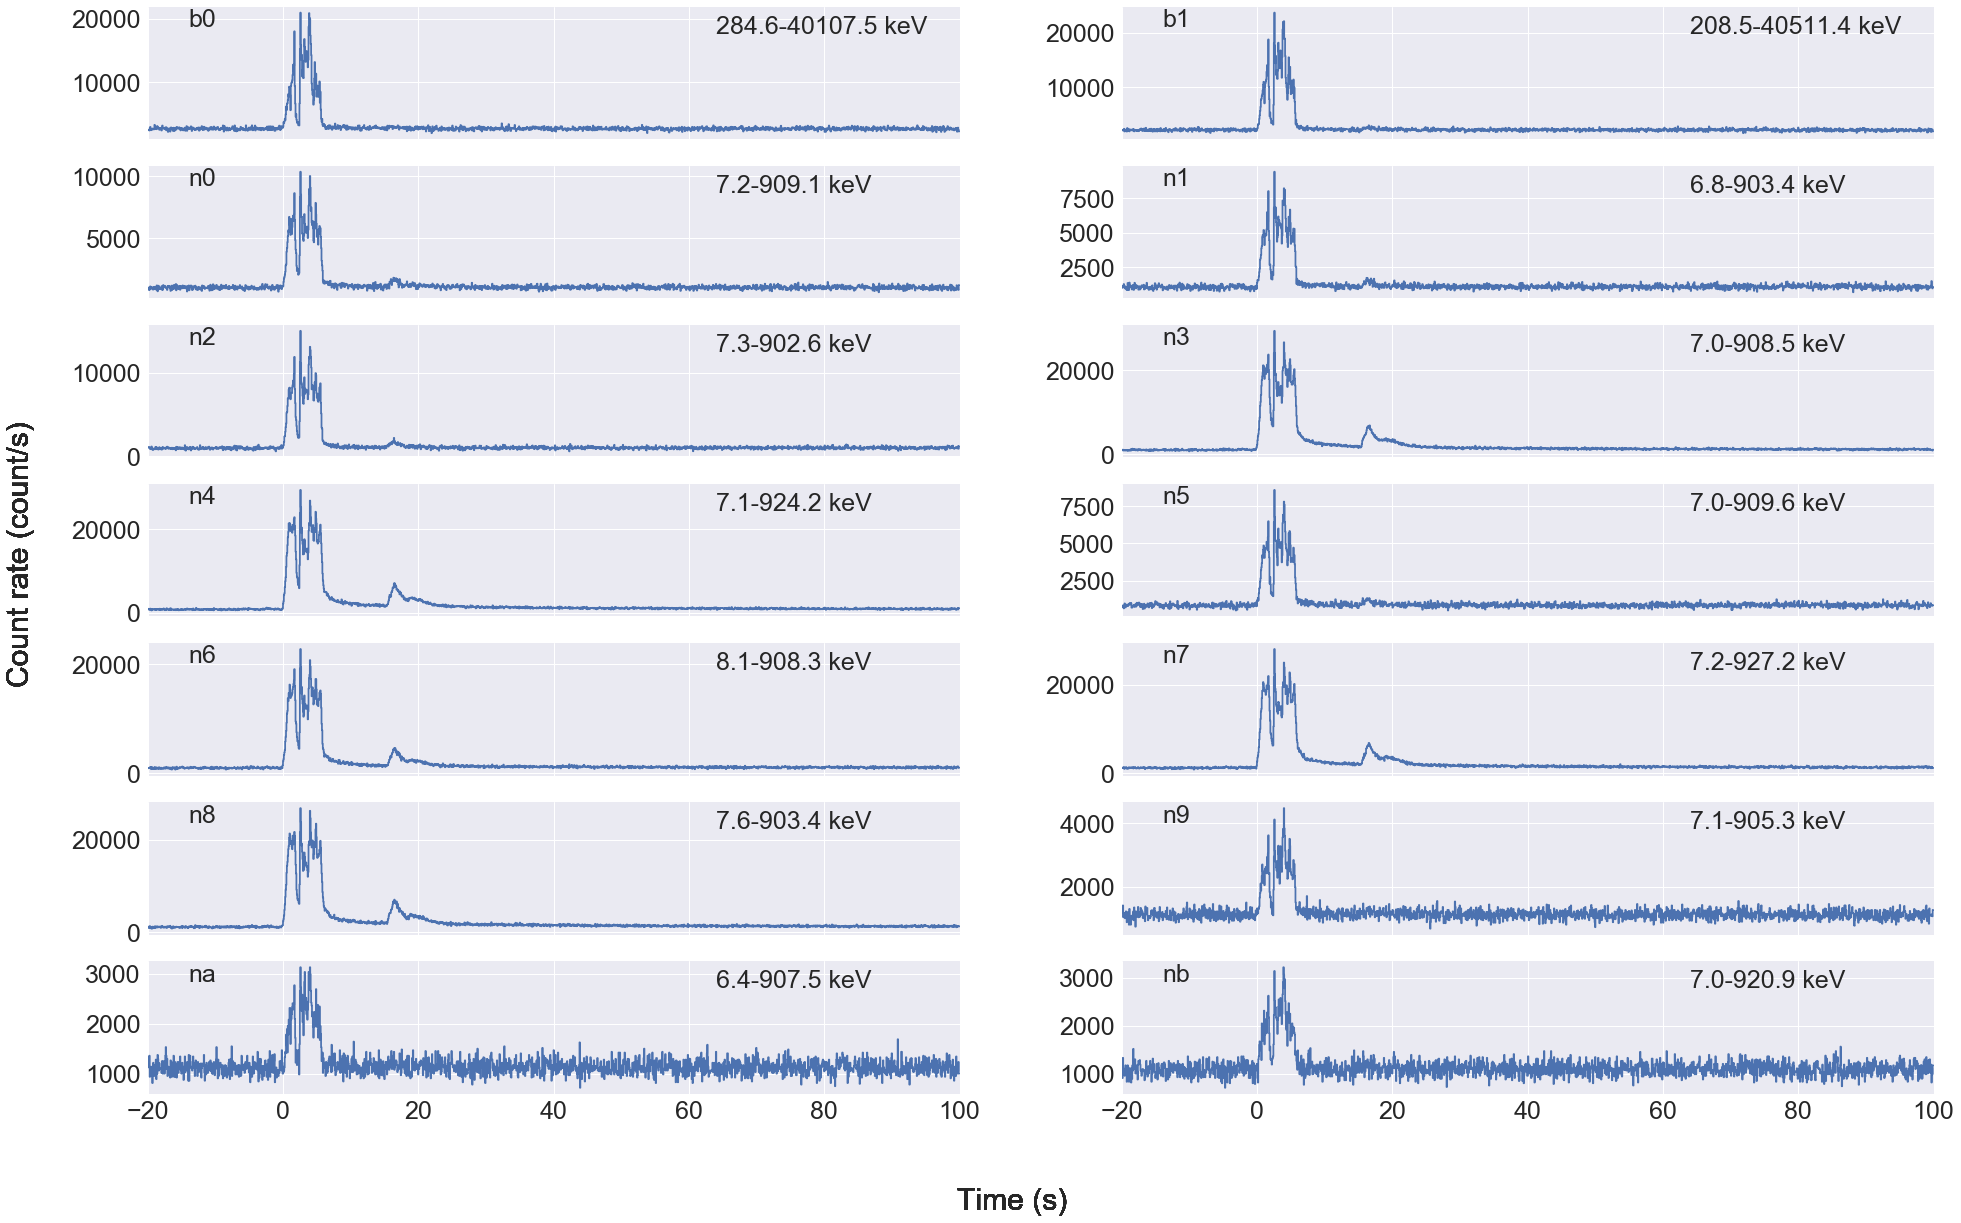

In [2]:
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import ticker
plt.style.use('seaborn')
import seaborn as sns
#sns.set(style='whitegrid')
from astropy.io import fits
from astropy.stats import bootstrap, jackknife_resampling
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pymc3 as pm
databasedir='/home/lang/work/GBM/burstdownload/data/'
bnname='bn190114873'
Det=['b0','b1','n0','n1','n2','n3','n4','n5',\
    'n6','n7','n8','n9','na','nb']
binwidth=0.064
viewt1=-20
viewt2=100
ch1=3
ch2=124
tbins=np.arange(viewt1,viewt2,binwidth)
fig, axes= plt.subplots(7,2,figsize=(32, 20),sharex=True,sharey=False)
for i in range(14):
    ttefile=glob(databasedir+'/2019/'+bnname+'/'+'glg_tte_'+Det[i]+'_'+bnname+'_v*.fit')
    hdu=fits.open(ttefile[0])
    trigtime=hdu['Primary'].header['TRIGTIME']
    data=hdu['EVENTS'].data
    time=data.field(0)-trigtime
    ch=data.field(1)
    #data in firt and last two channels of BGO and NaI are not used
    #ignore 0,1,2,125,126,127, notice 3-124
    goodindex=(ch>=ch1) & (ch<=ch2)  
    time=time[goodindex]
    ebound=hdu['EBOUNDS'].data
    emin=ebound.field(1)
    emin=emin[ch1:ch2+1]
    emax=ebound.field(2)
    emax=emax[ch1:ch2+1]
    histvalue, histbin =np.histogram(time,bins=tbins)
    plotrate=histvalue/binwidth
    #plotrate=bootstrap(plotrate,1)[0]
    #plotrate=np.concatenate(([plotrate[0]],plotrate))
    plotrate=jackknife_resampling(plotrate)[23]
    plotrate=np.concatenate(([plotrate[0]],[plotrate[0]],plotrate))
    axes[i//2,i%2].plot(histbin,plotrate,drawstyle='steps')
    axes[i//2,i%2].set_xlim([viewt1,viewt2])
    axes[i//2,i%2].tick_params(labelsize=25)
    axes[i//2,i%2].text(0.05,0.85,Det[i],transform=\
                            axes[i//2,i%2].transAxes,fontsize=25)
    axes[i//2,i%2].text(0.7,0.80,str(round(emin[0],1))+'-'+\
                                str(round(emax[-1],1))+' keV',\
                                transform=axes[i//2,i%2].transAxes,fontsize=25)
    fig.text(0.07, 0.5, 'Count rate (count/s)', ha='center', va='center',\
                                                 rotation='vertical',fontsize=30)
    fig.text(0.5, 0.05, 'Time (s)', ha='center', va='center',fontsize=30)
plt.show()
plt.close()

In [4]:
ttefile=glob(databasedir+'/2019/'+bnname+'/'+'glg_tte_'+Det[3]+'_'+bnname+'_v*.fit')
hdu=fits.open(ttefile[0])
trigtime=hdu['Primary'].header['TRIGTIME']
data=hdu['EVENTS'].data
time=data.field(0)-trigtime
ch=data.field(1)
#data in firt and last two channels of BGO and NaI are not used
#ignore 0,1,2,125,126,127, notice 3-124
goodindex=(ch>=ch1) & (ch<=ch2)  
time=time[goodindex]
ebound=hdu['EBOUNDS'].data
emin=ebound.field(1)
emin=emin[ch1:ch2+1]
emax=ebound.field(2)
emax=emax[ch1:ch2+1]
histvalue, histbin =np.histogram(time,bins=tbins)
plotrate=histvalue/binwidth
plotrate0=np.concatenate(([plotrate[0]],plotrate))

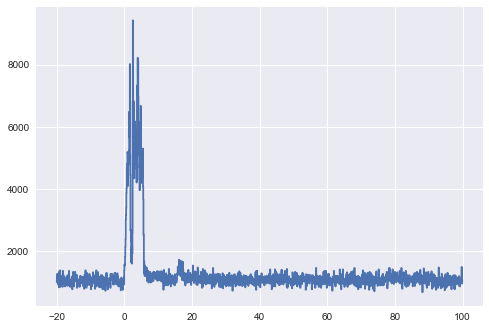

In [5]:
plt.plot(histbin,plotrate0,drawstyle='steps')

In [29]:
alpha = 1.0/plotrate.mean()
with pm.Model() as mymodel:
    lambda_ = pm.Exponential("lambda_", alpha)
    y_pred = pm.Poisson('y_pred', mu=lambda_, observed=plotrate)
    trace0 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda_]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:09<00:00, 2275.34draws/s]
The acceptance probability does not match the target. It is 0.9144547070347033, but should be close to 0.8. Try to increase the number of tuning steps.


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7915961208>,
      dtype=object)

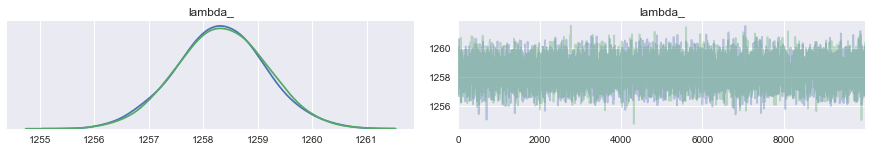

In [30]:
pm.traceplot(trace0)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7920a58ac8>,
      dtype=object)

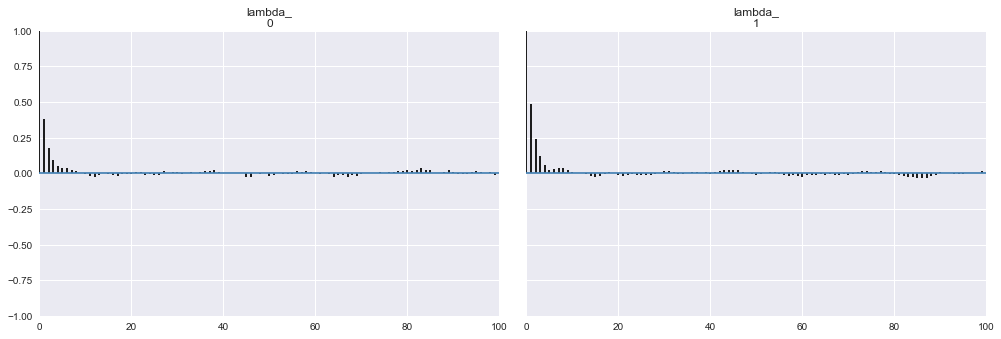

In [31]:
pm.autocorrplot(trace0)

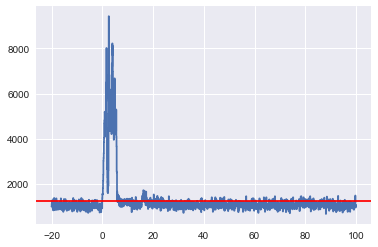

In [32]:
plt.plot(histbin,plotrate0,drawstyle='steps')
plt.axhline(trace0['lambda_'].mean(),color='red')

In [33]:
with pm.Model() as mymodel1:
    mu = pm.Normal('mu', mu=0, sd=2000)
    epsilon = pm.HalfCauchy('epsilon', 1000)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=plotrate)
    trace1 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:10<00:00, 2007.23draws/s]


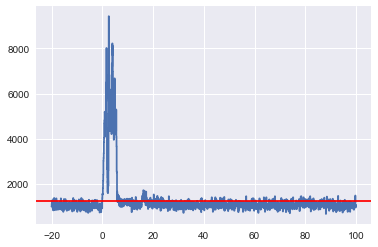

In [35]:
plt.plot(histbin,plotrate0,drawstyle='steps')
plt.axhline(trace1['mu'].mean(),color='red')

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f790995b860>,
      dtype=object)

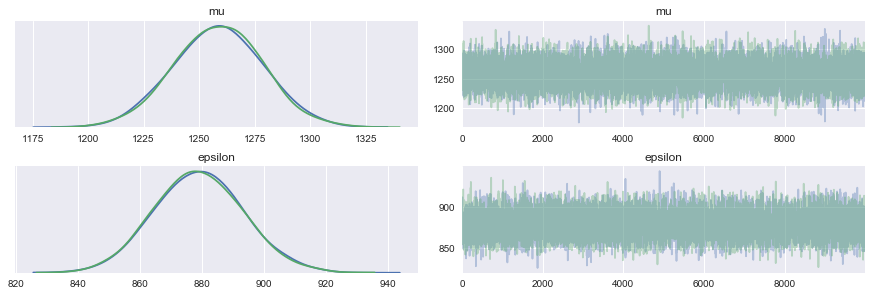

In [36]:
pm.traceplot(trace1)

In [37]:
trace1['mu'].mean()

1258.6987411902167

In [38]:
trace0['lambda_'].mean()

1258.3323218669198

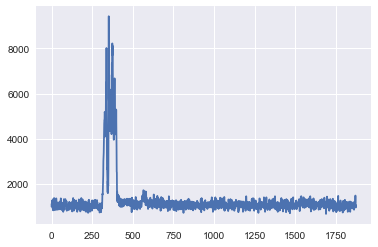

In [43]:
plt.plot(plotrate)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7903652358>,
      dtype=object)

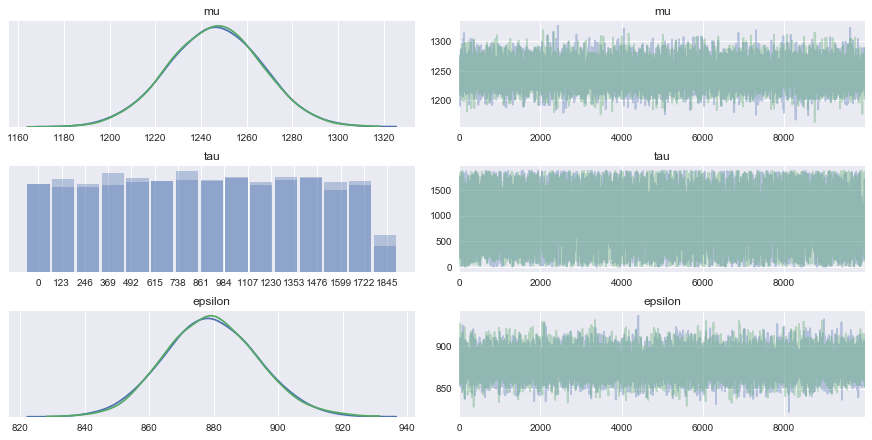

In [42]:
pm.traceplot(trace2)

NameError: name 'lambda_d' is not defined

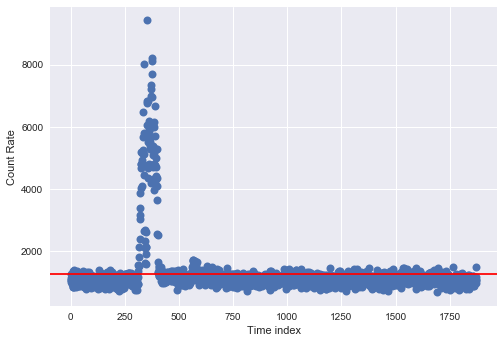

In [29]:
# https://docs.pymc.io/notebooks/getting_started.html

import pandas as pd
countrate_data = pd.Series(plotrate)
years = np.arange(len(plotrate))
alpha = 1.0/plotrate.mean()

plt.plot(years, disaster_data, 'o', markersize=8)
plt.axhline(plotrate.mean(),color='red')
plt.ylabel("Count Rate")
plt.xlabel("Time index")


with pm.Model() as disaster_model:

    switchpoint1 = pm.DiscreteUniform('switchpoint1', lower=years.min(), upper=years.max()-1)
    switchpoint2 = pm.DiscreteUniform('switchpoint2', lower=switchpoint1, upper=years.max())
    #burst_rate = pm.Normal('burst_rate', mu=1000, sigma=1000)
    burst_rate = pm.Exponential("burst_rate", alpha)
    background_rate = pm.Normal("background_rate", mu=plotrate.mean(), sigma=1)

    #rate = pm.math.switch((switchpoint1 <= years) & (switchpoint2 >= years), burst_rate, background_rate)
    
 
    countrate = pm.Poisson('countrate', lambda_d, observed=countrate_data)
    
    trace = pm.sample(draws=40000, tune=10000)

    
pm.traceplot(trace)